# Temporal Graph Attention Network (TGAT)


---

## Environment/Installs

In [1]:
import torch
import os

TORCH_VERSION = torch.__version__.split('+')[0]
CUDA_VERSION = torch.version.cuda
if CUDA_VERSION:
  CUDA_VERSION = "cu" + CUDA_VERSION.replace('.', '')
else:
  CUDA_VERSION = "cpu"

print(f"Installing for PyTorch {TORCH_VERSION} and {CUDA_VERSION}")
PYG_URL = f"https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html"
!pip install torch-scatter torch-sparse -f {PYG_URL}
!pip install torch-geometric
!pip install torch-geometric-temporal

print("All libraries installed correctly!")

Installing for PyTorch 2.8.0 and cu126
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
All libraries installed correctly!


## Imports

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.data import TemporalData
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import IdentityMessage, LastAggregator
from tqdm import tqdm

# -------------------------
# 1. Configuration
# -------------------------
pd.set_option('display.max_rows', None)
torch.set_printoptions(linewidth=1000, profile="full")

In [3]:
# -------------------------
# 2. Load & Preprocess Data
# -------------------------
# Load raw comorbidity transitions, convert timestamps, map ICD codes to a
# compact node index space, remove duplicate reciprocal edges, and apply
# log-time scaling. The output is a TemporalData object suitable for TGN/TGAT

edges_file = "/disease_edges.csv"
df = pd.read_csv(edges_file)

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')
df = df.dropna(subset=['timestamp']).copy()

# Map raw disease codes to contiguous node IDs [0, num_nodes)
# so that they can be used as indices in PyTorch tensors
all_nodes = set(df['src'].unique()) | set(df['dst'].unique())
node_mapper = {code: i for i, code in enumerate(all_nodes)}
df['src'] = df['src'].map(node_mapper)
df['dst'] = df['dst'].map(node_mapper)
num_nodes = len(all_nodes)

df['min_node'] = np.minimum(df['src'].values, df['dst'].values)
df['max_node'] = np.maximum(df['src'].values, df['dst'].values)
df = df.drop_duplicates(subset=['min_node', 'max_node', 'timestamp'])
df = df.drop(columns=['min_node', 'max_node'])

t_raw = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds().values
t_log = np.log(t_raw + 1.0)
df['timestamp'] = (t_log * 1000.0).astype(np.int64)
df = df.sort_values('timestamp').reset_index(drop=True)

# Pack the preprocessed edges into a TemporalData object:
#  - src, dst: node IDs
#  - t: log-scaled integer timestamps
#  - msg: fixed 16-dim message for each event (used by TGN memory)
#  - y: dummy labels (not used directly in training loop)
data = TemporalData(
    src=torch.tensor(df['src'].values, dtype=torch.long),
    dst=torch.tensor(df['dst'].values, dtype=torch.long),
    t=torch.tensor(df['timestamp'].values, dtype=torch.long),
    msg=torch.ones(len(df), 16),
    y=torch.zeros(len(df), dtype=torch.long)
)

# Chronological split: first 70% of events for training, next 15% for
# validation, and final 15% for testing
train_idx = int(len(data) * 0.70)
val_idx = int(len(data) * 0.85)
train_data = data[:train_idx]
val_data = data[train_idx:val_idx]
test_data = data[val_idx:]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class NeighborFinder:
    """
    Lightweight neighbor index that stores a fixed-size buffer
    of its most recent neighbors and interaction times, for each node
      - Runs entirely on the GPU (no Python loops over events).
      - Supports streaming updates during training/evaluation.
      - Returns only neighbors that occurred strictly before a query time,
          so we never "look ahead" when building attention edges.
    """

class NeighborFinder:
    def __init__(self, num_nodes, max_neighbors=50, device='cpu'):
        self.device = device
        self.max_neighbors = max_neighbors
        self.num_nodes = num_nodes

        # Pre-allocate memory for neighbors and timestamps
        self.neighbor_store = torch.full((num_nodes, max_neighbors), -1, dtype=torch.long, device=device)       #recent neighbors of node u
        self.time_store = torch.full((num_nodes, max_neighbors), -1.0, dtype=torch.float, device=device)        #timestamps of those interactions
        self.ptrs = torch.zeros(num_nodes, dtype=torch.long, device=device)                                     #write pointer (for circular buffer) for node u

    def add_edges(self, src, dst, t):
        """
        Insert a batch of directed edges (src -> dst and dst -> src) into
        the circular neighbor buffers
        Args:
            src, dst: 1D LongTensors of node IDs for this batch of events.
            t:        1D tensor of event times (same length as src/dst).
        """
        # vectorized for speed
        all_src = torch.cat([src, dst])
        all_dst = torch.cat([dst, src])
        all_t   = torch.cat([t, t]).float()

        current_ptrs = self.ptrs[all_src] % self.max_neighbors
        self.neighbor_store[all_src, current_ptrs] = all_dst
        self.time_store[all_src, current_ptrs] = all_t

        ones = torch.ones_like(all_src, dtype=torch.long)
        self.ptrs.scatter_add_(0, all_src, ones)

    def get_temporal_neighbors(self, source_nodes, timestamps):
        """
        Return neighbors that interacted with each source node before
        the given query time
        For each node u in `source_nodes`:
          - Look up its stored neighbors and interaction times.
          - Keep only those neighbors with time < query_time[u].
          - Build an edge_index (neighbor -> u) and relative times
        """

        neighbors = self.neighbor_store[source_nodes]
        edge_times = self.time_store[source_nodes]

        query_times = timestamps.unsqueeze(1).expand_as(edge_times)
        mask = (neighbors != -1) & (edge_times < query_times)

        valid_row_idx, valid_col_idx = mask.nonzero(as_tuple=True)

        found_neighbors = neighbors[valid_row_idx, valid_col_idx]
        found_targets = source_nodes[valid_row_idx]
        found_times = edge_times[valid_row_idx, valid_col_idx]
        rel_times = query_times[valid_row_idx, valid_col_idx] - found_times

        edge_index = torch.stack([found_neighbors, found_targets], dim=0)
        return edge_index, rel_times

In [5]:
# -------------------------
# 4. Model Components
# -------------------------
class TGNMemory(TGNMemory):
    @property
    def device(self):
        return self.memory.device

class ScaledTimeEncoder(nn.Module):
    def __init__(self, base_encoder, scale=1000.0):
        super().__init__()
        self.base_encoder = base_encoder
        self.scale = scale
    def forward(self, t):
        return self.base_encoder(t.float() / self.scale)

class TGATEmbedding(nn.Module):
    """
    Two-layer temporal graph attention encoder

    Inputs:
        - z_all:       current memory embeddings for all nodes
        - edge_index:  tensor of (neighbor, target) edges
        - rel_t_float: tensor of time differences between query and neighbor
    """
    def __init__(self, memory_dim, time_dim, embedding_dim, time_enc, heads, dropout):
        super().__init__()
        self.time_enc = time_enc

        self.conv1 = TransformerConv(
            in_channels=memory_dim,
            out_channels=embedding_dim // heads,
            heads=heads,
            edge_dim=time_dim,
            dropout=dropout
        )
        self.conv2 = TransformerConv(
            in_channels=embedding_dim,
            out_channels=embedding_dim // heads,
            heads=heads,
            edge_dim=time_dim,
            dropout=dropout
        )

    def forward(self, z_all, edge_index, rel_t_float):
        if edge_index.size(1) == 0:
            return z_all

        edge_attr = self.time_enc(rel_t_float)

        # Layer 1
        z_hidden = self.conv1(z_all, edge_index, edge_attr=edge_attr)
        z_hidden = z_hidden.relu()

        # Layer 2 + Residual
        z_out = self.conv2(z_hidden, edge_index, edge_attr=edge_attr)
        return z_out + z_all

class LinkPredictor(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_1 = nn.Linear(in_channels * 2, in_channels)
        self.lin_2 = nn.Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = torch.cat([z_src, z_dst], dim=-1)
        return self.lin_2(self.lin_1(h).relu()).squeeze(-1)

In [6]:
# -------------------------
# 5. Initialization
# -------------------------
memory_dim = 256
time_dim = 256
embedding_dim = 256
heads = 8
dropout = 0.1
msg_dim = 16

# TGNMemory keeps a learnable "state" for each node, updated after every event
memory = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=msg_dim,
    memory_dim=memory_dim,
    time_dim=time_dim,
    message_module=IdentityMessage(msg_dim, memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

memory.time_enc = ScaledTimeEncoder(memory.time_enc).to(device)

# Temporal attention encoder that will read from the neighbor subgraphs
# returned by NeighborFinder
tgat_gnn = TGATEmbedding(
    memory_dim=memory_dim,
    time_dim=time_dim,
    embedding_dim=embedding_dim,
    time_enc=memory.time_enc,
    heads=heads,
    dropout=dropout,
).to(device)

predictor = LinkPredictor(embedding_dim).to(device)
neighbor_finder = NeighborFinder(num_nodes=num_nodes, max_neighbors=50, device=device)

# optimize memory parameters, TGAT encoder, and link predictor
optimizer = torch.optim.Adam(
    list(memory.parameters()) + list(tgat_gnn.parameters()) + list(predictor.parameters()),
    lr=0.0005,
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
criterion = torch.nn.BCEWithLogitsLoss()

/usr/local/lib/python3.12/dist-packages/torch/_compile.py:53: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


## Training and Evaluation functions

In [7]:
# -------------------------
# 6. Training Logic
# -------------------------
def get_batch_embeddings_tgat(src, dst, t):
    """
    Build a time-aware subgraph for the current batch and run TGAT

    Args:
        src, dst: 1D LongTensors of node IDs for this batch.
        t:        1D tensor of timestamps for this batch.

    Returns:
        emb_src, emb_dst: [B, embedding_dim] embeddings for src and dst.
    """
    z_all = memory.memory

    # Sample neighbors for SRC and DST
    idx_src, t_src = neighbor_finder.get_temporal_neighbors(src, t)
    idx_dst, t_dst = neighbor_finder.get_temporal_neighbors(dst, t)

    # Combine graphs
    full_edge_index = torch.cat([idx_src, idx_dst], dim=1)
    full_edge_times = torch.cat([t_src, t_dst], dim=0)

    # Run GNN
    z_updated = tgat_gnn(z_all, full_edge_index, full_edge_times)

    return z_updated[src], z_updated[dst]

def train():
    memory.train()
    tgat_gnn.train()
    predictor.train()
    memory.reset_state()
    global neighbor_finder
    neighbor_finder = NeighborFinder(num_nodes=num_nodes, max_neighbors=50, device=device)

    total_loss = 0.0
    batch_size = 200

    d_src = train_data.src.to(device)
    d_dst = train_data.dst.to(device)
    d_t   = train_data.t.to(device)
    d_msg = train_data.msg.to(device)

    num_events = len(train_data)
    num_batches = 0

    for i in tqdm(range(0, num_events, batch_size), desc="Training"):
        batch_idx = slice(i, min(i + batch_size, num_events))
        src = d_src[batch_idx]
        dst = d_dst[batch_idx]
        t   = d_t[batch_idx]
        msg = d_msg[batch_idx]

        if len(src) == 0: break
        optimizer.zero_grad()

        # 1. Embeddings
        emb_src, emb_dst = get_batch_embeddings_tgat(src, dst, t)

        # 2. Positive
        pos_out = predictor(emb_src, emb_dst)
        pos_loss = criterion(pos_out, torch.ones_like(pos_out))

        # 3. Negative
        rand_dst = torch.randint(0, num_nodes, (len(src),), device=device)
        _, emb_neg = get_batch_embeddings_tgat(src, rand_dst, t)

        neg_out  = predictor(emb_src, emb_neg)
        neg_loss = criterion(neg_out, torch.zeros_like(neg_out))

        loss = pos_loss + neg_loss
        loss.backward()
        optimizer.step()

        # 4. History Update (Post-Prediction)
        neighbor_finder.add_edges(src, dst, t)
        with torch.no_grad():
            memory.update_state(src, dst, t, msg)
        memory.detach()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(1, num_batches)

@torch.no_grad()
def test(inference_data):
    memory.eval()
    tgat_gnn.eval()
    predictor.eval()

    d_src = inference_data.src.to(device)
    d_dst = inference_data.dst.to(device)
    d_t   = inference_data.t.to(device)
    d_msg = inference_data.msg.to(device)

    total_auc, total_ap = [], []
    total_hits10 = []

    batch_size = 200
    K_neg = 50

    for i in range(0, len(inference_data), batch_size):
        batch_idx = slice(i, min(i + batch_size, len(inference_data)))
        src, dst = d_src[batch_idx], d_dst[batch_idx]
        t, msg   = d_t[batch_idx], d_msg[batch_idx]
        B = len(src)
        if B == 0: break

        # 1. Standard Embeddings
        emb_src, emb_dst = get_batch_embeddings_tgat(src, dst, t)

        # 2. Standard Negatives
        rand_dst = torch.randint(0, num_nodes, (B,), device=device)
        _, emb_neg = get_batch_embeddings_tgat(src, rand_dst, t)

        pos_prob = predictor(emb_src, emb_dst).sigmoid()
        neg_prob = predictor(emb_src, emb_neg).sigmoid()

        y_pred = torch.cat([pos_prob, neg_prob]).cpu().numpy()
        y_true = np.concatenate([np.ones(B), np.zeros(B)])

        try:
            total_auc.append(roc_auc_score(y_true, y_pred))
            total_ap.append(average_precision_score(y_true, y_pred))
        except: pass

        # 3. HITS@10 (Ranking)
        # We need embeddings for many negatives
        many_neg_dst = torch.randint(0, num_nodes, (B, K_neg), device=device)
        flat_neg_dst = many_neg_dst.view(-1)
        flat_t       = t.unsqueeze(1).repeat(1, K_neg).view(-1)

        # Get embeddings for flat negatives by treating them as "src"
        emb_many_neg_flat, _ = get_batch_embeddings_tgat(flat_neg_dst, flat_neg_dst, flat_t)
        emb_many_negs = emb_many_neg_flat.view(B, K_neg, embedding_dim)

        emb_src_expanded = emb_src.unsqueeze(1).repeat(1, K_neg, 1)

        neg_scores = predictor(emb_src_expanded, emb_many_negs).sigmoid()
        pos_scores = pos_prob.unsqueeze(1)
        rankings = (neg_scores > pos_scores).sum(dim=1) + 1
        total_hits10.append((rankings <= 10).float().mean().item())

        # Update History
        neighbor_finder.add_edges(src, dst, t)
        memory.update_state(src, dst, t, msg)

    return np.mean(total_auc), np.mean(total_ap), np.mean(total_hits10)

Start TGAT Training...


Training: 100%|██████████| 10810/10810 [09:29<00:00, 18.98it/s]


Epoch: 01, Loss: 0.3137 | Val AUC: 0.9599  AP: 0.9560  Hits@10: 0.8047


Training: 100%|██████████| 10810/10810 [09:28<00:00, 19.02it/s]


Epoch: 02, Loss: 0.2626 | Val AUC: 0.9609  AP: 0.9580  Hits@10: 0.8325


Training: 100%|██████████| 10810/10810 [09:28<00:00, 19.00it/s]


Epoch: 03, Loss: 0.2473 | Val AUC: 0.9619  AP: 0.9594  Hits@10: 0.8495


Training: 100%|██████████| 10810/10810 [09:27<00:00, 19.06it/s]


Epoch: 04, Loss: 0.2249 | Val AUC: 0.9616  AP: 0.9591  Hits@10: 0.7793


Training: 100%|██████████| 10810/10810 [09:26<00:00, 19.08it/s]


Epoch: 05, Loss: 0.2174 | Val AUC: 0.9609  AP: 0.9573  Hits@10: 0.7881


Training: 100%|██████████| 10810/10810 [09:28<00:00, 19.00it/s]


Epoch: 06, Loss: 0.2143 | Val AUC: 0.9598  AP: 0.9557  Hits@10: 0.7611


Training: 100%|██████████| 10810/10810 [09:29<00:00, 18.99it/s]


Epoch: 07, Loss: 0.2038 | Val AUC: 0.9615  AP: 0.9581  Hits@10: 0.8300


Training: 100%|██████████| 10810/10810 [09:29<00:00, 18.97it/s]


Epoch: 08, Loss: 0.2015 | Val AUC: 0.9600  AP: 0.9557  Hits@10: 0.8040


Training: 100%|██████████| 10810/10810 [09:29<00:00, 18.97it/s]


Epoch: 09, Loss: 0.2000 | Val AUC: 0.9611  AP: 0.9574  Hits@10: 0.8039


Training: 100%|██████████| 10810/10810 [09:29<00:00, 18.97it/s]


Epoch: 10, Loss: 0.1949 | Val AUC: 0.9598  AP: 0.9549  Hits@10: 0.7485
TEST RESULTS | AUC: 0.9624  AP: 0.9572  Hits@10: 0.7717
Plot saved to tgat_training_metrics.png


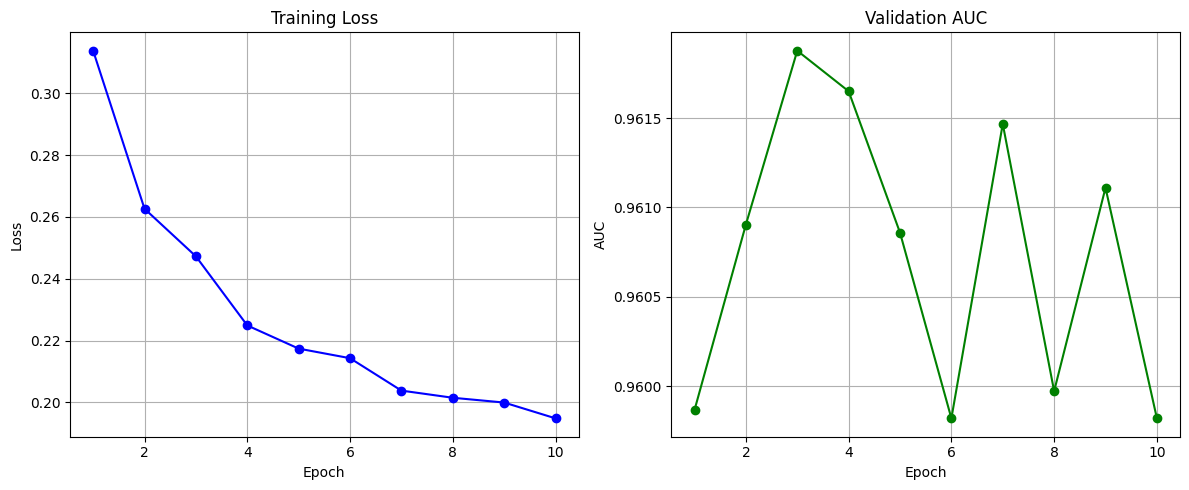

In [8]:
# -------------------------
# 7. Training loop
# -------------------------
print("Start TGAT Training...")
epoch_losses = []
epoch_val_aucs = []

for epoch in range(1, 11):
    loss = train()
    val_auc, val_ap, val_hits = test(val_data)
    scheduler.step()

    epoch_losses.append(loss)
    epoch_val_aucs.append(val_auc)

    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f} | Val AUC: {val_auc:.4f}  AP: {val_ap:.4f}  Hits@10: {val_hits:.4f}')

test_auc, test_ap, test_hits = test(test_data)
print(f'TEST RESULTS | AUC: {test_auc:.4f}  AP: {test_ap:.4f}  Hits@10: {test_hits:.4f}')

# --- PLOTTING ---
plt.figure(figsize=(12, 5))
# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
# Subplot 2: Validation AUC
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_val_aucs)+1), epoch_val_aucs, marker='o', label='Val AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC')
plt.grid(True)
plt.tight_layout()
plt.savefig('tgat_training_metrics.png')
print("Plot saved to tgat_training_metrics.png")